<a href="https://colab.research.google.com/github/Cammwr/DATA3000/blob/main/Food_Sales_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Our foundation libs
import numpy as np
import pandas as pd
import warnings

#Packages for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

#PACF - ACF(Used to measure correlations across different lengths of time/Shorter lengths of time. )
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Data modeling
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
#Datasets obtained from Kaggle
holidays = 'holidays_events.csv'
holidays = pd.read_csv(holidays)

oil = 'oil.csv'
oil = pd.read_csv(oil)

stores = 'stores.csv'
stores = pd.read_csv(stores)

transactions = 'transactions.csv'
transactions = pd.read_csv(transactions)

train_data = 'train.csv'
train_data = pd.read_csv(train_data)

test_data = 'test.csv'
test_data = pd.read_csv(test_data)

In [ ]:
#Data cleaining - drop NAs
train_data_cleaned = train_data.dropna()
test_data_cleaned = test_data.dropna()
holidays_cleaned = holidays.dropna()
stores_cleaned = stores.dropna()
oil_cleaned = oil.dropna()
transactions_cleaned = transactions.dropna()

In [ ]:
train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])

In [ ]:
family_data = train_data_cleaned.groupby('family')['sales'].sum().reset_index()

In [ ]:
family_data

,family,sales
0,AUTOMOTIVE,554822.00
1,BABY CARE,10051.00
2,BEAUTY,337893.00
3,BEVERAGES,216954486.00
4,BOOKS,6438.00
5,BREAD/BAKERY,42133945.58
6,CELEBRATION,761177.00
7,CLEANING,97521289.00
8,DAIRY,64487709.00
9,DELI,24110322.47


In [ ]:
train_data_cleaned

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.13,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8


In [ ]:
sales_by_date = train_data_cleaned.groupby('date')['sales'].sum().reset_index()

In [ ]:
sales_by_date

,date,sales
0,2013-01-01,2511.62
1,2013-01-02,496092.42
2,2013-01-03,361461.23
3,2013-01-04,354459.68
4,2013-01-05,477350.12
...,...,...
1679,2017-08-11,826373.72
1680,2017-08-12,792630.54
1681,2017-08-13,865639.68
1682,2017-08-14,760922.41


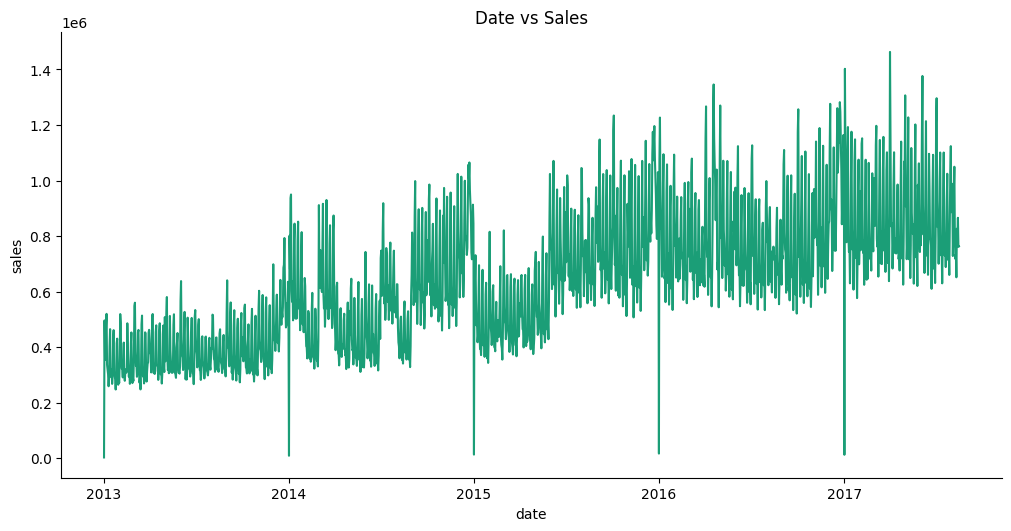

In [ ]:
# @title date vs sales

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['sales']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sales_by_date.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
plt.title('Date vs Sales')
_ = plt.ylabel('sales')

In [ ]:
sales_by_date['weekday'] = sales_by_date['date'].dt.day_name()
sales_by_date['month'] = sales_by_date['date'].dt.month_name()
sales_by_date['year'] = sales_by_date['date'].dt.year
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
sales_by_date['season'] = sales_by_date['date'].dt.month.apply(get_season)

In [ ]:
sales_by_date

,date,sales,weekday,month,year,season
0,2013-01-01,2511.62,Tuesday,January,2013,Winter
1,2013-01-02,496092.42,Wednesday,January,2013,Winter
2,2013-01-03,361461.23,Thursday,January,2013,Winter
3,2013-01-04,354459.68,Friday,January,2013,Winter
4,2013-01-05,477350.12,Saturday,January,2013,Winter
...,...,...,...,...,...,...
1679,2017-08-11,826373.72,Friday,August,2017,Summer
1680,2017-08-12,792630.54,Saturday,August,2017,Summer
1681,2017-08-13,865639.68,Sunday,August,2017,Summer
1682,2017-08-14,760922.41,Monday,August,2017,Summer


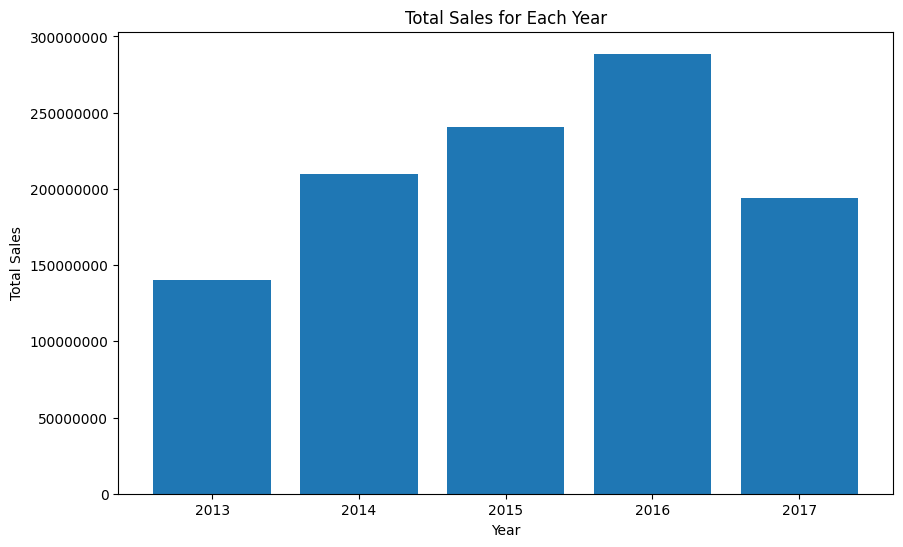

In [ ]:
#Total sales per year
total_sales_per_year = sales_by_date.groupby('year')['sales'].sum()

plt.figure(figsize=(10, 6))
plt.bar(total_sales_per_year.index, total_sales_per_year.values)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales for Each Year')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(total_sales_per_year.index, [int(year) for year in total_sales_per_year.index])
plt.show()

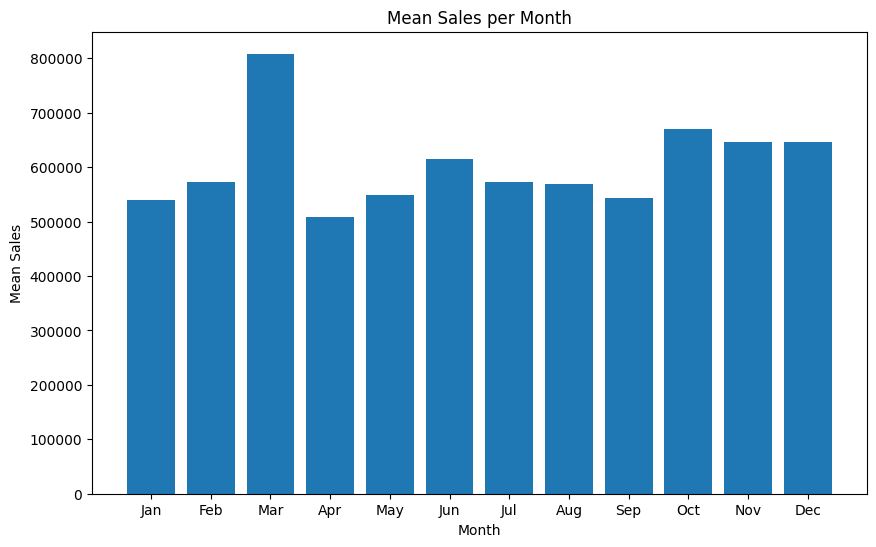

In [ ]:
sales_by_date_filtered = sales_by_date[sales_by_date['date'].dt.year != 2017]

mean_sales_per_month = sales_by_date_filtered.groupby(['month'])['sales'].mean()

plt.figure(figsize=(10, 6))
plt.bar(mean_sales_per_month.index, mean_sales_per_month.values)
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.title('Mean Sales per Month')
plt.xticks(mean_sales_per_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

season
Fall     653543.54
Spring   613686.40
Summer   633675.99
Winter   654103.90
Name: sales, dtype: float64


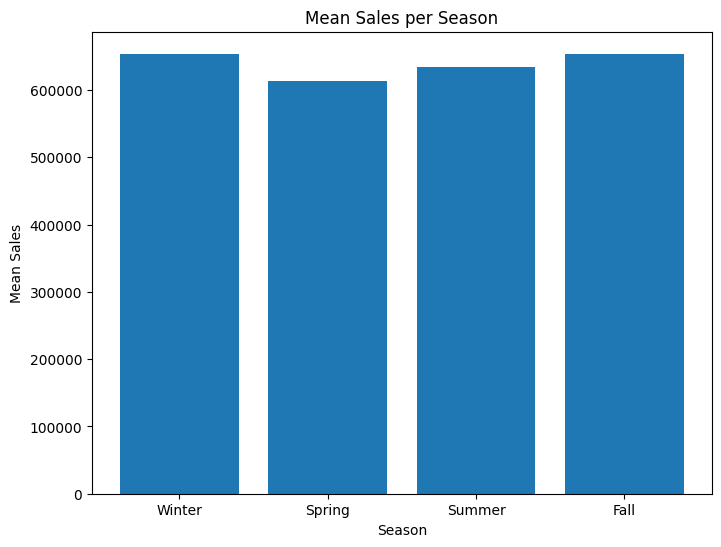

In [ ]:
mean_sales_per_season = sales_by_date.groupby('season')['sales'].mean()
print(mean_sales_per_season)
seasons_order = ['Winter', 'Spring', 'Summer', 'Fall']
mean_sales_per_season = mean_sales_per_season.reindex(seasons_order)

plt.figure(figsize=(8, 6))
plt.bar(mean_sales_per_season.index, mean_sales_per_season.values)
plt.xlabel('Season')
plt.ylabel('Mean Sales')
plt.title('Mean Sales per Season')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

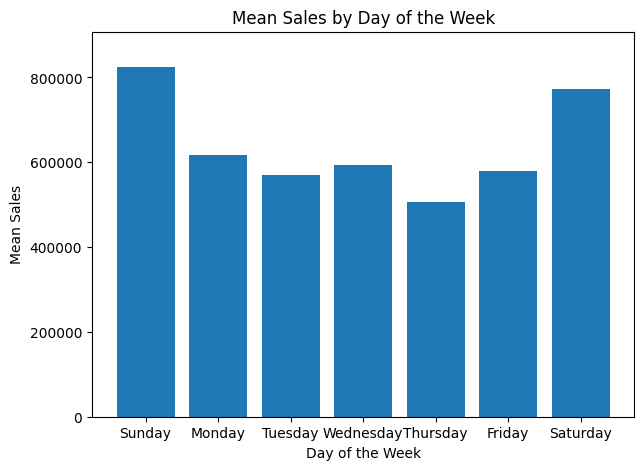

In [ ]:
sales_by_day = sales_by_date.groupby('weekday')['sales'].mean()

weekdays_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

sales_by_day = sales_by_day.reindex(weekdays_order)

plt.figure(figsize=(7, 5))
plt.bar(sales_by_day.index, sales_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Mean Sales')
plt.title('Mean Sales by Day of the Week')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, sales_by_day.max() * 1.1)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_pivot = sales_by_date.pivot_table(index='weekday', columns='month', values='sales', aggfunc='mean')
sales_pivot = sales_pivot.reindex(index=weekday_order, columns=months_order)

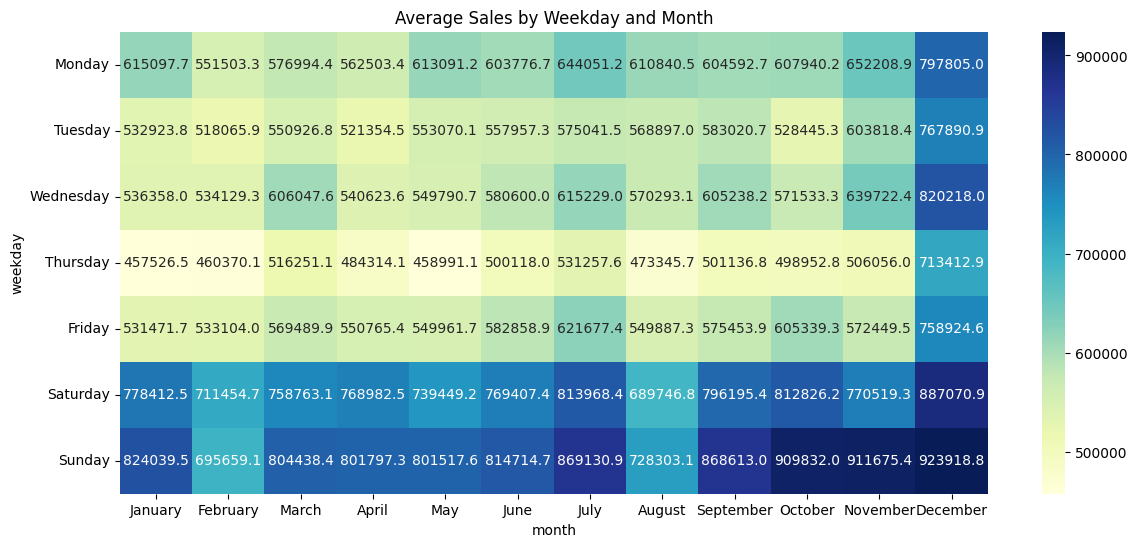

In [ ]:
plt.figure(figsize=(14, 6))
sns.heatmap(sales_pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Sales by Weekday and Month')
plt.show()

In [ ]:
sales_pivot2 = sales_by_date_filtered.pivot_table(index='weekday', columns='month', values='sales', aggfunc='mean')
sales_pivot2 = sales_pivot2.reindex(index=weekday_order, columns=months_order)

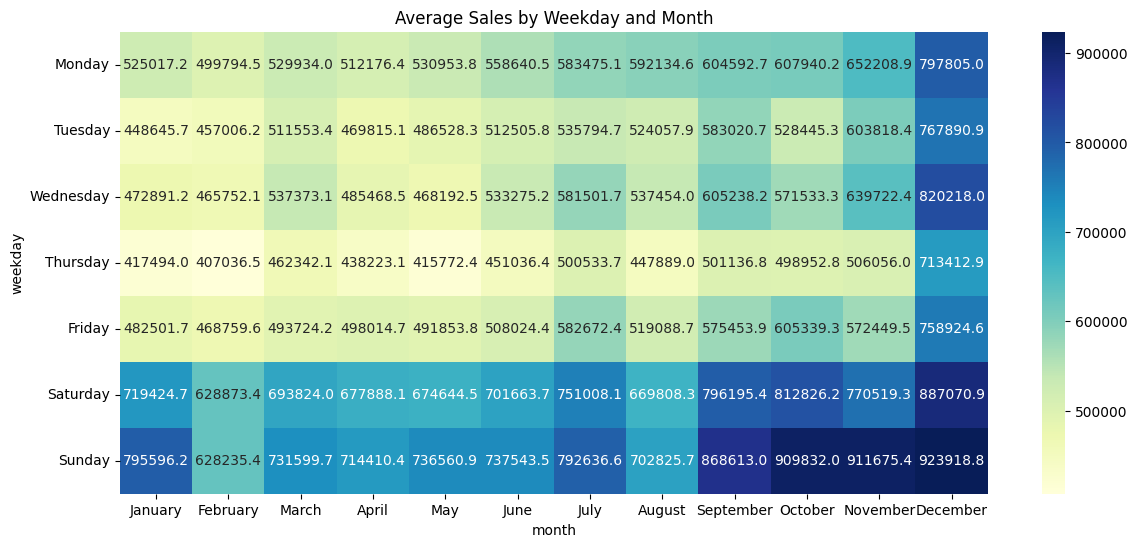

In [ ]:
plt.figure(figsize=(14, 6))
sns.heatmap(sales_pivot2, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Sales by Weekday and Month')
plt.show()

In [ ]:
categories = list(family_data.keys())
sales_values = list(family_data.values())

# Plot pie chart with percentages
plt.figure(figsize=(10, 8))
plt.pie(sales_values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Sales by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [ ]:

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming 'sales_by_date' is your DataFrame with the sales data

# Convert the 'sales' column to numeric data type
sales_by_date['sales'] = pd.to_numeric(sales_by_date['sales'])

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(sales_by_date) * 0.8)
train_data, test_data = sales_by_date.iloc[:train_size], sales_by_date.iloc[train_size:]

# Fit the ARIMA model to the training data
model = ARIMA(train_data['sales'], order=(5,1,0))  # Example order, you can tune this
model_fit = model.fit()

# Make predictions on the testing set
forecast = model_fit.forecast(steps=len(test_data))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['sales'], forecast)
print('Mean Squared Error (MSE):', mse)


Mean Squared Error (MSE): 34921030357.93878


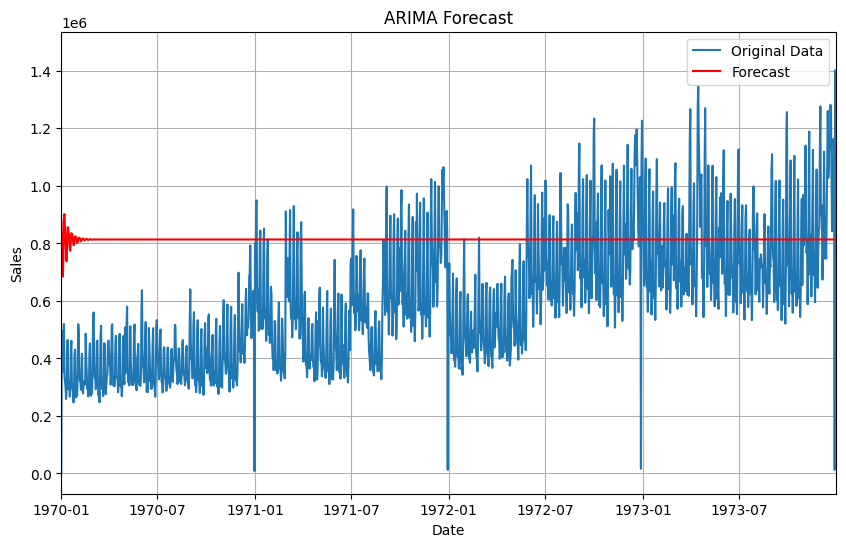

In [ ]:
import matplotlib.pyplot as plt

# Plot the original sales data
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date.index, sales_by_date['sales'], label='Original Data')

# Plot the forecasted values
forecast_index = pd.date_range(start=sales_by_date.index[-1], periods=365 * 4 + 1, freq='D')  # Extend forecast until 2024
forecast = model_fit.forecast(steps=len(forecast_index))
plt.plot(forecast_index, forecast, color='red', label='Forecast')

# Set x-axis limit to include the forecast period
plt.xlim(left=sales_by_date.index[0], right=forecast_index[-1])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()


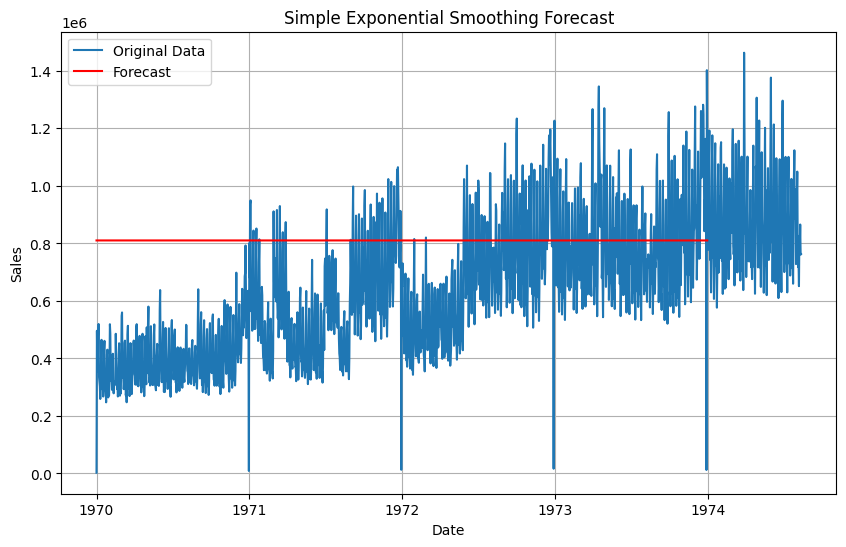

In [ ]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt

# Assuming 'sales_by_date' is your DataFrame with the sales data

# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(sales_by_date['sales'])
model_fit = model.fit()

# Make forecasts
forecast = model_fit.forecast(steps=365 * 4)  # Forecast for 4 years

# Plot original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date.index, sales_by_date['sales'], label='Original Data')
plt.plot(pd.date_range(start=sales_by_date.index[-1], periods=len(forecast), freq='D'), forecast, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Simple Exponential Smoothing Forecast')
plt.legend()
plt.grid(True)
plt.show()


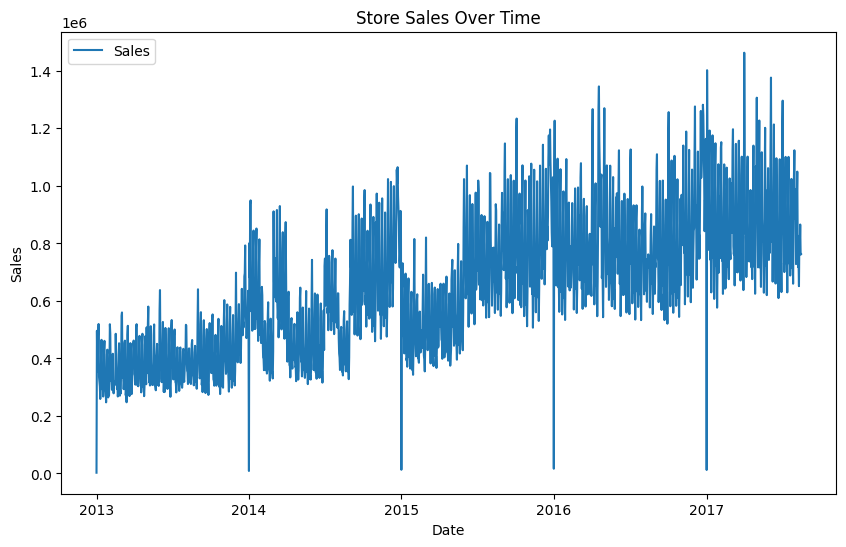

In [ ]:
sales_by_date.set_index('date', inplace=True)
sales_by_date.sort_index(inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date.index, sales_by_date['sales'], label='Sales')
plt.title('Store Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
train_size = int(len(sales_by_date) * 0.8)
train_data, test_data = sales_by_date.iloc[:train_size], sales_by_date.iloc[train_size:]

In [ ]:
# Define features (X) and target variable (y)
X_train, y_train = train_data.index.values.reshape(-1, 1), train_data['sales']
X_test, y_test = test_data.index.values.reshape(-1, 1), test_data['sales']

# Initialize and train the model (Random Forest Regressor)
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)


Mean Squared Error: 51480421976.28117


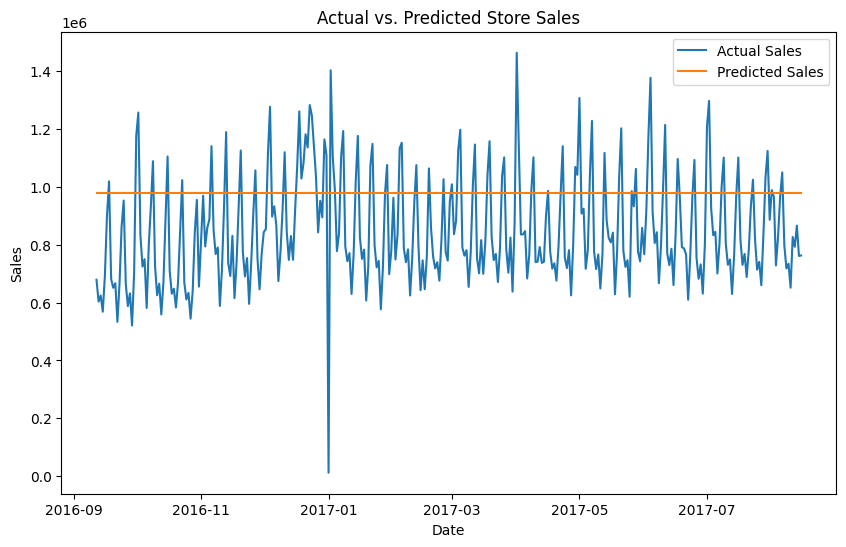

In [ ]:
# Plot actual vs. predicted sales
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Actual Sales')
plt.plot(test_data.index, predictions, label='Predicted Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


#New

##Training the Model

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

sales_by_date.index = pd.to_datetime(sales_by_date.index)

train = sales_by_date[sales_by_date.index.year < 2017]
test = sales_by_date[sales_by_date.index.year == 2017]

model = ARIMA(train['sales'], order=(5,1,0))
model_fit = model.fit()

start = pd.to_datetime('2017-01-01')
end = pd.to_datetime('2017-01-7')
predictions = model_fit.get_prediction(start=start, end=end)

predicted_values = predictions.predicted_mean
actual_values = test['sales']

rmse = sqrt(mean_squared_error(actual_values, predicted_values))
print('Test RMSE: %.3f' % rmse)



KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
import numpy as np

train = sales_by_date[sales_by_date.index.year < 2017]
test = sales_by_date[sales_by_date.index.year == 2017]

model = ARIMA(train['sales'], order=(5,1,0))
model_fit = model.fit()

predictions = []

for i in range(len(test)):
  next_pred = model_fit.forecast(steps=1)[0]
  predictions.append(next_pred)

predictions = np.array(predictions)

rmse = sqrt(mean_squared_error(test['sales'], predictions))
print('Test RMSE: %.3f' % rmse)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
print(sales_by_date.columns)

Index(['sales', 'weekday', 'month', 'year', 'season'], dtype='object')


In [ ]:
X = sales_by_date.index
y = sales_by_date['sales']

In [ ]:
split_date = '2017-01-01'  # Specify the split date

# Convert split date to datetime format
split_date = pd.to_datetime(split_date)


sales_by_date.index = pd.to_datetime(sales_by_date.index)
# Split the data into training and testing sets
train_dates = sales_by_date.index
train_data = sales_by_date[train_dates <= split_date]
test_data = sales_by_date[train_dates > split_date]


#

# Check the size of the training and testing sets
print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))

Training data size: 1458
Testing data size: 226


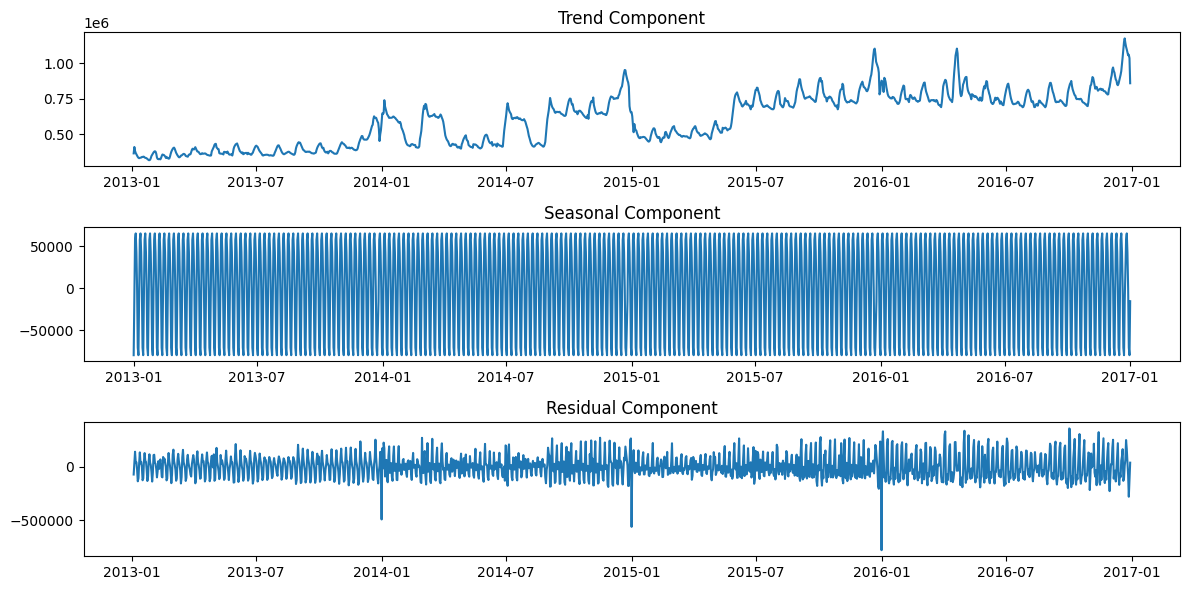

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(train_data['sales'], period=7)  # Assuming weekly seasonal pattern

# Extract decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot individual components
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(trend)
plt.title('Trend Component')
plt.subplot(312)
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.subplot(313)
plt.plot(residual)
plt.title('Residual Component')
plt.tight_layout()
plt.show()


In [ ]:
#sales_by_date.set_index('date', inplace=True)

# Resample the data to a daily frequency (if it's not already in that frequency)

# Fill in any missing values or gaps in the data (if necessary)
sales_by_date.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Fit the ARIMA model
model = ARIMA(sales_by_date['sales'], order=(9,2,8))  # Example order, you can tune this
model_fit = model.fit()

In [ ]:
forecast = model_fit.forecast(steps=209)
print("Forecasted Sales:")
print(forecast)

Forecasted Sales:
2017-08-16   688483.96
2017-08-17   593488.01
2017-08-18   742298.77
2017-08-19   902174.91
2017-08-20   951941.77
                ...   
2018-03-08   726414.12
2018-03-09   819950.89
2018-03-10   947006.80
2018-03-11   983150.18
2018-03-12   912225.76
Freq: D, Name: predicted_mean, Length: 209, dtype: float64


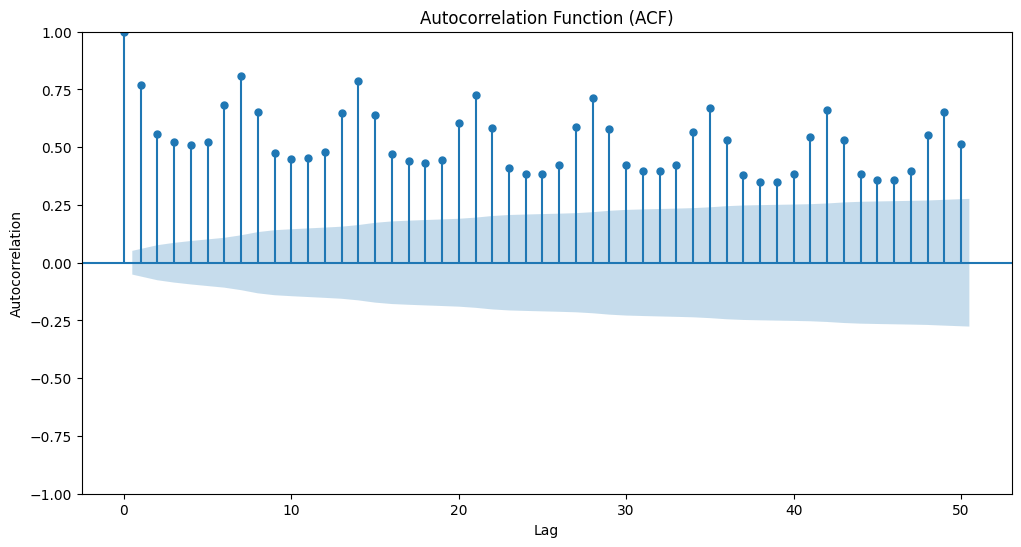

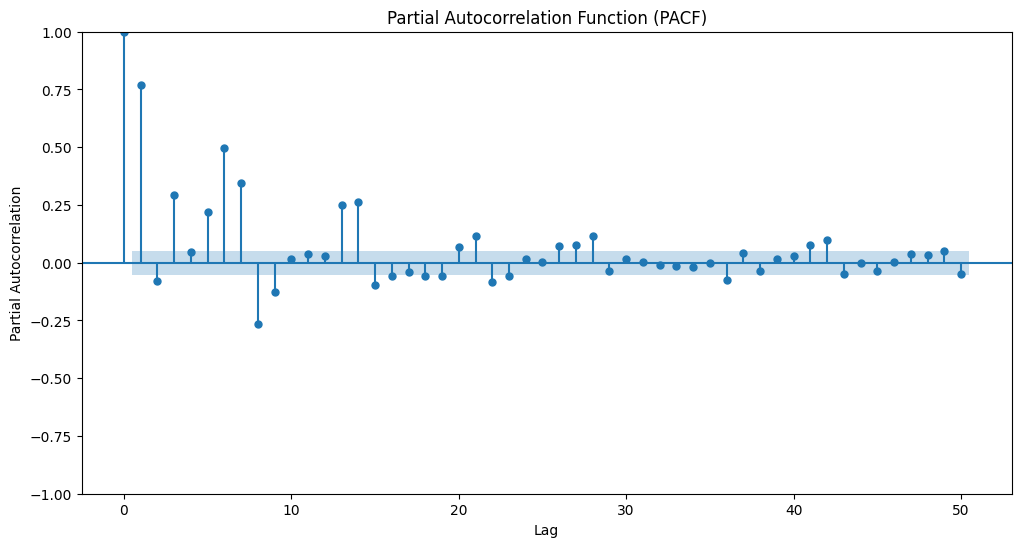

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate ACF plot
plt.figure(figsize=(12, 6))
plot_acf(train_data['sales'], lags=50, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Generate PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(train_data['sales'], lags=50, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


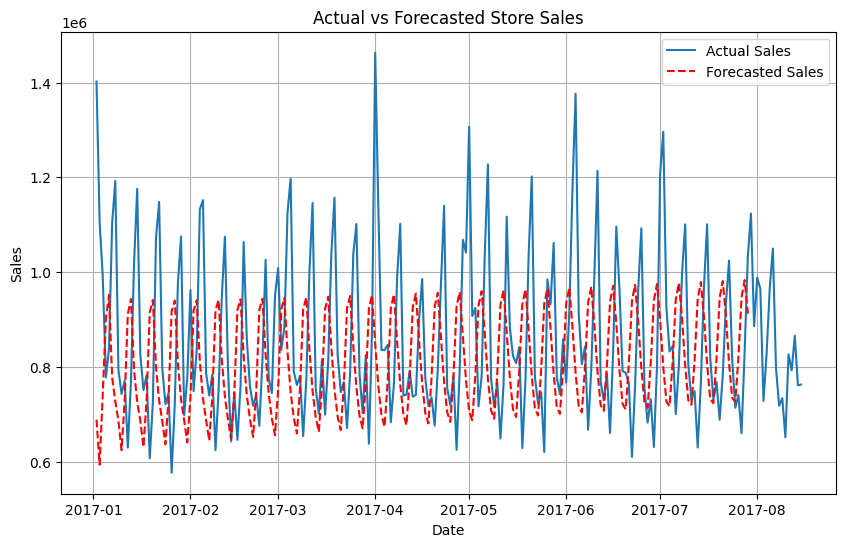

In [ ]:
import matplotlib.pyplot as plt

# Create an index for the forecasted values using the test_data index
forecast_index = pd.date_range(start=test_data.index[0], periods=len(forecast))

# Plot actual sales
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['sales'], label='Actual Sales')

# Plot forecasted sales with the forecast_index
plt.plot(forecast_index, forecast, color='red', linestyle='--', label='Forecasted Sales')

plt.title('Actual vs Forecasted Store Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
